### Code by Denis Loechel as part of master thesis on synthetic data generation

# Importing libraries

In [1]:
# Standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# CTGAN 
from sdv.tabular import CTGAN
from sdv.evaluation import evaluate
from ctgan import CTGAN, load_demo
from sdv.sampling import Condition
from sdv.tabular import CopulaGAN
from sdv.sampling import Condition

#Packages for AdaSyn
from imblearn.over_sampling import ADASYN

# File handling
import sys
from io import StringIO
# Synthetic data quality assessment
import math
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from scipy.stats import wasserstein_distance

# Assessments
from sdmetrics import load_demo
from sdmetrics.reports.single_table import QualityReport
from sdmetrics.reports.single_table import DiagnosticReport
from sdmetrics.reports.utils import get_column_plot
from sdmetrics.reports import utils
from sdmetrics.column_pairs import CorrelationSimilarity
import json

In [2]:
# Uploading our previous HR dataset
data = pd.read_csv("20230308_Updated_HR_dataset.csv")

In [70]:
# Check to see if everything is the way it should be 
data.shape

(311, 18)

## Approach 1: CTGAN

In [393]:
# For some reason I needed to import these packages again even though I already did it above
from sdv.tabular import CTGAN
from sdv.sampling import Condition

# Sampling all columns
target_columns = data.columns.tolist()

# Making sure we are able to save the verbose i.e. the discriminator and generator output per epoch
verbose_output = StringIO()
sys.stdout = verbose_output

# CTGAN model with custom hyperparameters 
model = CTGAN(
    generator_lr=1e-5,
    #generator_decay=1e-4,
    discriminator_lr=1e-5,
    #discriminator_decay=1e-4,
    generator_dim=(256,256,256),
    discriminator_dim=(256,256,256),
    epochs=10000,
    batch_size=1000,
    verbose=True
)

# Fit the model to the data
model.fit(data[target_columns])

sys.stdout = sys.__stdout__

# Defining the conditions to alleviate our class imbalance for the CitizenDesc column
condition_0 = Condition({'CitizenDesc': 0}, num_rows=5000)  
condition_1 = Condition({'CitizenDesc': 1}, num_rows=5000)  
condition_2 = Condition({'CitizenDesc': 2}, num_rows=5000)

# Generating synthetic data based on our conditions above
synthetic_data = model.sample_conditions(
    conditions=[condition_0, condition_1, condition_2],
    max_tries_per_batch=1000
)

Sampling conditions:   0%|                            | 0/15000 [00:00<?, ?it/s]/Users/denisloechel/opt/anaconda3/envs/Test/lib/python3.9/site-packages/sdv/tabular/base.py:599: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for group, dataframe in grouped_conditions:
/Users/denisloechel/opt/anaconda3/envs/Test/lib/python3.9/site-packages/sdv/tabular/base.py:632: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for transformed_group, transformed_dataframe in transformed_groups:
Sampling conditions:  33%|█████▎          | 4996/15000 [00:06<00:13, 723.68it/s]/Users/denisloechel/opt/anaconda3/envs/Test/lib/python3.9/site-packages/sdv/tabular/base.py:

In [394]:
# Passing the verbose output to a pandas dataframe 
df_verbose = pd.DataFrame([x.split(',') for x in verbose_output.getvalue().split('\n')[:-1]], 
                          columns=["epoch", "g_loss", "d_loss"])

# Converting epoch column to int 
df_verbose["epoch"] = df_verbose["epoch"].str.replace("Epoch" , '').astype(int)

# Removing all text so that we can chart below
df_verbose["g_loss"] = df_verbose["g_loss"].str.replace("Loss G: ", '').astype(float)
df_verbose["d_loss"] = df_verbose["d_loss"].str.replace("Loss D: ", '').astype(float)

In [395]:
# Checking the verbose dataframe 
df_verbose.head(-1)

,epoch,g_loss,d_loss
0,1,0.0052,-0.0075
1,2,-0.0080,-0.0074
2,3,0.0043,-0.0053
3,4,0.0052,-0.0038
4,5,-0.0023,-0.0048
...,...,...,...
9994,9995,0.3164,-0.4681
9995,9996,0.1455,-0.7475
9996,9997,0.1212,-0.5300
9997,9998,0.3004,-0.6460


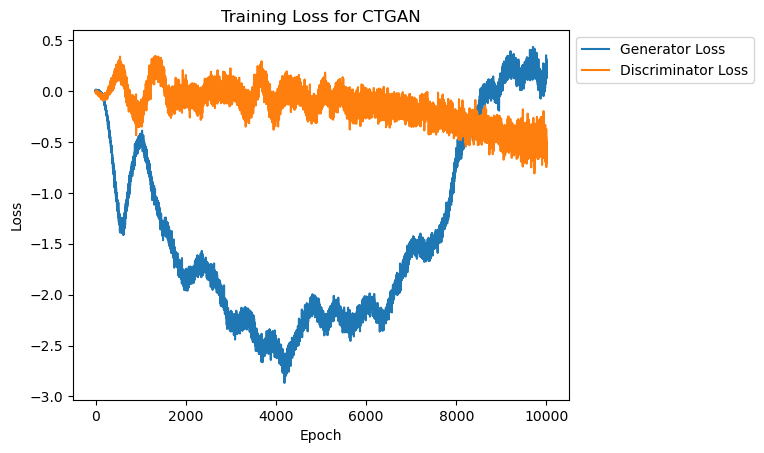

In [396]:
# Plotting the verbose output
plt.plot(df_verbose["epoch"], df_verbose["g_loss"], label='Generator Loss')
plt.plot(df_verbose["epoch"], df_verbose["d_loss"], label='Discriminator Loss')

# x and y axis label and title
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss for CTGAN")
plt.legend(loc="upper left", bbox_to_anchor=(1.0, 1.0))
plt.show()

In [397]:
synthetic_data.head()

,EmpID,MarriedID,GenderID,DeptID,Salary,Termd,PositionID,CitizenDesc,ManagerID,EmpSatisfaction,SpecialProjectsCount,DaysLateLast30,Absences,BirthYear,YearofTermination,YearofHire,YearofPerformanceReview,YearsinCompany
0,10221,1,0,5,54088,0,19,0,22,4,0,0,14,1987,-1,2017,2019,0
1,10126,1,0,5,45046,0,10,0,17,4,0,0,3,1975,95,2013,2016,8
2,10069,1,0,3,96806,1,20,0,18,3,5,0,9,1979,26,2008,2011,0
3,10001,1,1,6,94248,1,19,0,14,5,5,0,19,1981,1900,2013,2019,0
4,10217,0,1,5,50364,0,30,0,23,3,0,0,11,1975,2018,2012,2019,0


In [398]:
synthetic_data["CitizenDesc"].value_counts()

0    5000
1    5000
2    5000
Name: CitizenDesc, dtype: int64

## Assessing utility for our CTGAN model

In [399]:
evaluate(synthetic_data, data)

0.8889334524234846

## Assessing privacy for our CTGAN model

### Distance to Closest Record (DCR) (Euclidian Distance) 

In [400]:
# Using our orginal dataset
data = data

# Load the synthetic dataset that we just saved
synthetic_data = synthetic_data

# Extracing all numerical columns so that we can compare DCR distance
numerical_columns = data.select_dtypes(include=np.number).columns.tolist()
data_numerical = data[numerical_columns]
synthetic_numerical = synthetic_data[numerical_columns]

# Calculate the DCR between the two datasets using the Euclidean distance metric
dcr_matrix = euclidean_distances(data_numerical, synthetic_numerical)
dcr = dcr_matrix.min(axis=1).mean()

# Compare the DCR of the two datasets
dcr

49.29516487136081

### Wasserstein Distance

In [401]:
# Using our orginal dataset
data = data

# Load the synthetic dataset that we just saved
synthetic_data = synthetic_data

# Extracing all numerical columns so that we can compare distances
numerical_columns = data.select_dtypes(include='number').columns.tolist()
data_numerical = data[numerical_columns]
synthetic_numerical = synthetic_data[numerical_columns]

# Calculate the Wasserstein distance between the numerical columns in the original and synthetic datasets
wasserstein_distances = [wasserstein_distance(data_numerical[column], synthetic_numerical[column]) for column in numerical_columns]

# Calculate the average Wasserstein distance between the two datasets
average_wasserstein_distance = sum(wasserstein_distances) / len(wasserstein_distances)

average_wasserstein_distance

162.09208430391806

In [402]:
synthetic_data = synthetic_data.apply(lambda x: [i if i >= 0 else 0 for i in x])
synthetic_data.to_csv("synthetic_dataset_CTGAN_epochs10000.csv", index=False)

## Approach 2: AdaSyn Generation

In [26]:
# Making sure we have our orginal dataset 
data = data

In [4]:
data.columns

Index(['EmpID', 'MarriedID', 'GenderID', 'DeptID', 'Salary', 'Termd',
       'PositionID', 'CitizenDesc', 'ManagerID', 'EmpSatisfaction',
       'SpecialProjectsCount', 'DaysLateLast30', 'Absences', 'BirthYear',
       'YearofTermination', 'YearofHire', 'YearofPerformanceReview',
       'YearsinCompany'],
      dtype='object')

In [5]:
# Focus is on columns with distinct class imbalances
# CitizenDesc 

In [6]:
target_column = "CitizenDesc" 
# Separate the features and target variable
X = data.drop(target_column, axis=1)
y = data[target_column]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create an instance of the AdaSyn class with n_neighbors=3
#sampling_strategy = {0: "auto", 1: "auto", 2: "auto"}
adasyn = ADASYN(n_neighbors= 3, random_state=42)

# Generate synthetic data using AdaSyn
X_train_newsamples, y_train_newsamples = adasyn.fit_resample(X_train, y_train)

# Convert the oversampled data back to pandas DataFrame and Series
X_train_newsamples = pd.DataFrame(X_train_newsamples, columns=X.columns)
y_train_newsamples = pd.Series(y_train_newsamples, name=y.name)

# Concatenate the oversampled data with the original data
X_syn = pd.concat([X_train, y_train_newsamples], axis=0)
y_syn = pd.concat([y_train, y_train_newsamples], axis=0)

In [7]:
# Check the number of instances in each class after oversampling
y_train_newsamples.value_counts()

2    236
1    236
0    232
Name: CitizenDesc, dtype: int64

In [8]:
# Save the oversampled data to a new CSV file
Adasyn_data = pd.concat([X_syn, y_syn], axis=1)

# assume your DataFrame is named 'df'
synthetic_data = Adasyn_data.drop(columns=[col for col in Adasyn_data.columns if col != "CitizenDesc"])

In [9]:
synthetic_data.head()

,CitizenDesc
109,2
247,2
234,2
202,2
78,2


In [10]:
# Saving to CSV
#Final_adaysn.to_csv("synthetic_dataset_Adasyn_c.csv", index=False)

In [11]:
# Load the synthetic dataset that we just saved
#synthetic_data = pd.read_csv('synthetic_dataset_Adasyn_c.csv')

In [12]:
synthetic_data.head()

,CitizenDesc
109,2
247,2
234,2
202,2
78,2


In [13]:
# Select the column to keep
column_to_keep = "CitizenDesc"

# Filter the dataframe to keep only the desired column
data = data.filter([column_to_keep], axis=1)

In [14]:
data.columns

Index(['CitizenDesc'], dtype='object')

In [15]:
synthetic_data.columns

Index(['CitizenDesc'], dtype='object')

In [16]:
# Using our orginal dataset
data = data

# Load the synthetic dataset that we just saved
synthetic_data = synthetic_data

# Extracing all numerical columns so that we can compare DCR distance
numerical_columns = data.select_dtypes(include=np.number).columns.tolist()
data_numerical = data[numerical_columns]
synthetic_numerical = synthetic_data[numerical_columns]

# Calculate the DCR between the two datasets using the Euclidean distance metric
dcr_matrix = euclidean_distances(data_numerical, synthetic_numerical)
dcr = dcr_matrix.min(axis=1).mean()

# Compare the DCR of the two datasets
dcr

0.0

In [17]:
# Using our orginal dataset
data = data

# Load the synthetic dataset that we just saved
synthetic_data = synthetic_data

# Extracing all numerical columns so that we can compare distances
numerical_columns = data.select_dtypes(include='number').columns.tolist()
data_numerical = data[numerical_columns]
synthetic_numerical = synthetic_data[numerical_columns]

# Calculate the Wasserstein distance between the numerical columns in the original and synthetic datasets
wasserstein_distances = [wasserstein_distance(data_numerical[column], synthetic_numerical[column]) for column in numerical_columns]

# Calculate the average Wasserstein distance between the two datasets
average_wasserstein_distance = sum(wasserstein_distances) / len(wasserstein_distances)

average_wasserstein_distance

0.6662703666675673

In [18]:
evaluate(synthetic_data, data)

0.5472452646653516

## Approach 3: CopulaGAN

In [177]:

# Sampling all columns
target_columns = data.columns.tolist()

# Making sure we are able to save the verbose i.e. the discriminator and generator output per epoch
verbose_output = StringIO()
sys.stdout = verbose_output

# CopulaGAN model  
model = CopulaGAN(
    generator_lr=1e-5,
    #generator_decay=1e-4,
    discriminator_lr=1e-5,
    #discriminator_decay=1e-4,
    generator_dim=(256,256,256),
    discriminator_dim=(256,256,256),
    epochs=2000,
    batch_size=1000,
    verbose=True
)

# Fit the model to the data
model.fit(data[target_columns])

sys.stdout = sys.__stdout__

# Defining the conditions to alleviate our class imbalance for the CitizenDesc column
condition_0 = Condition({'CitizenDesc': 0}, num_rows=5000)  
condition_1 = Condition({'CitizenDesc': 1}, num_rows=5000)  
condition_2 = Condition({'CitizenDesc': 2}, num_rows=5000)

# Generating synthetic data based on our conditions above
synthetic_data = model.sample_conditions(
    conditions=[condition_0, condition_1, condition_2],
    max_tries_per_batch=1000
)

Sampling conditions:   0%|                            | 0/15000 [00:00<?, ?it/s]/Users/denisloechel/opt/anaconda3/envs/Test/lib/python3.9/site-packages/sdv/tabular/base.py:599: FutureWarning:

In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.

/Users/denisloechel/opt/anaconda3/envs/Test/lib/python3.9/site-packages/sdv/tabular/base.py:632: FutureWarning:

In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.

Sampling conditions:  33%|█████▋           | 5000/15000 [02:34<05:17, 31.49it/s]/Users/denisloechel/opt/anaconda3/envs/Test/lib/python3.9/site-packages/sdv/tabular/base.py:632: FutureWarning:

In a future version of pandas, a length 1 tuple will be returned when iterating over a grou

In [178]:
# Passing the verbose output to a pandas dataframe 
df_verbose = pd.DataFrame([x.split(',') for x in verbose_output.getvalue().split('\n')[:-1]], 
                          columns=["epoch", "g_loss", "d_loss"])

# Converting epoch column to int 
df_verbose["epoch"] = df_verbose["epoch"].str.replace("Epoch" , '').astype(int)

# Removing all text so that we can chart below
df_verbose["g_loss"] = df_verbose["g_loss"].str.replace("Loss G: ", '').astype(float)
df_verbose["d_loss"] = df_verbose["d_loss"].str.replace("Loss D: ", '').astype(float)

In [179]:
# Checking the verbose dataframe 
df_verbose.head(-1)

,epoch,g_loss,d_loss
0,1,-0.0207,0.0070
1,2,-0.0164,0.0160
2,3,-0.0173,-0.0186
3,4,-0.0167,-0.0074
4,5,-0.0191,-0.0042
...,...,...,...
1994,1995,-1.3085,0.0660
1995,1996,-1.3646,0.0069
1996,1997,-1.3189,0.0080
1997,1998,-1.4156,0.1520


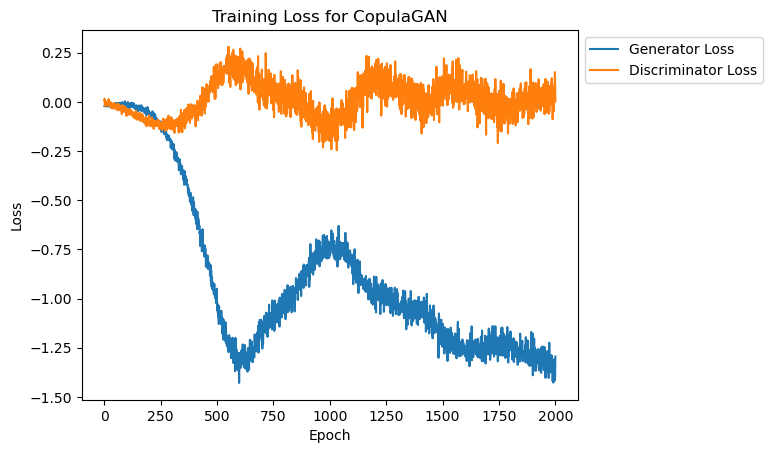

In [180]:
# Plotting the verbose output
plt.plot(df_verbose["epoch"], df_verbose["g_loss"], label='Generator Loss')
plt.plot(df_verbose["epoch"], df_verbose["d_loss"], label='Discriminator Loss')

# x and y axis label and title
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss for CopulaGAN")
plt.legend(loc="upper left", bbox_to_anchor=(1.0, 1.0))
plt.show()

In [181]:
synthetic_data["CitizenDesc"].value_counts()

0    5000
1    5000
2    5000
Name: CitizenDesc, dtype: int64

In [183]:
evaluate(synthetic_data, data)

0.8455270453733478

## Assessing privacy for our CopulaGAN model

### Distance to Closest Record (DCR) (Euclidian Distance) 

In [184]:
# Using our orginal dataset
data = data

# Load the synthetic dataset that we just saved
synthetic_data = synthetic_data

# Extracing all numerical columns so that we can compare DCR distance
numerical_columns = data.select_dtypes(include=np.number).columns.tolist()
data_numerical = data[numerical_columns]
synthetic_numerical = synthetic_data[numerical_columns]

# Calculate the DCR between the two datasets using the Euclidean distance metric
dcr_matrix = euclidean_distances(data_numerical, synthetic_numerical)
dcr = dcr_matrix.min(axis=1).mean()

# Compare the DCR of the two datasets
dcr

53.23333900524907

### Wasserstein Distance

In [186]:
# Using our orginal dataset
data = data

# Load the synthetic dataset that we just saved
synthetic_data = synthetic_data

# Extracing all numerical columns so that we can compare distances
numerical_columns = data.select_dtypes(include='number').columns.tolist()
data_numerical = data[numerical_columns]
synthetic_numerical = synthetic_data[numerical_columns]

# Calculate the Wasserstein distance between the numerical columns in the original and synthetic datasets
wasserstein_distances = [wasserstein_distance(data_numerical[column], synthetic_numerical[column]) for column in numerical_columns]

# Calculate the average Wasserstein distance between the two datasets
average_wasserstein_distance = sum(wasserstein_distances) / len(wasserstein_distances)

average_wasserstein_distance

210.05121332618793

In [187]:
synthetic_data = synthetic_data.apply(lambda x: [i if i >= 0 else 0 for i in x])
synthetic_data.to_csv("synthetic_dataset_CopulaGANepochs2000.csv", index=False)

# Further Real vs. Synthetic Dataset Metrics Comparison

## Real Data vs. CTGAN Synthetic Dataset

In [3]:
#real_data, synthetic_data, metadata = load_demo(modality='single_table')

## Quality Report
### Overview

In [16]:
real_data = pd.read_csv("20230308_Updated_HR_dataset.csv")
synthetic_data = pd.read_csv("synthetic_dataset_CopulaGANepochs2000.csv")
metadata=json.load(open("metadata.json", "r"))
report = QualityReport()
report.generate(real_data, synthetic_data, metadata)

Creating report: 100%|████████████████████████████| 4/4 [00:00<00:00,  9.05it/s]


Overall Quality Score: 87.53%

Properties:
Column Shapes: 81.99%
Column Pair Trends: 93.07%


In [102]:
report.get_details(property_name='Column Shapes')

,Column,Metric,Quality Score
0,EmpID,KSComplement,0.994741
1,MarriedID,KSComplement,0.948580
2,GenderID,KSComplement,0.996217
3,DeptID,KSComplement,0.828962
4,Salary,KSComplement,0.686179
5,Termd,KSComplement,0.875672
6,PositionID,KSComplement,0.688692
7,CitizenDesc,KSComplement,0.384780
8,ManagerID,KSComplement,0.868483
9,EmpSatisfaction,KSComplement,0.908697


In [36]:
report.get_visualization(property_name='Column Pair Trends')

## Diagnostic Report
### Overview

In [17]:
real_data = pd.read_csv("20230308_Updated_HR_dataset.csv")
synthetic_data = pd.read_csv("synthetic_dataset_CopulaGANepochs2000.csv")
metadata=json.load(open("metadata.json", "r"))
report = DiagnosticReport()
report.generate(real_data, synthetic_data, metadata)

Creating report: 100%|████████████████████████████| 4/4 [00:03<00:00,  1.13it/s]


DiagnosticResults:

SUCCESS:
✓ The synthetic data covers over 90% of the numerical ranges present in the real data
✓ Over 90% of the synthetic rows are not copies of the real data
✓ The synthetic data follows over 90% of the min/max boundaries set by the real data


In [19]:
report.get_properties()

{'Coverage': 0.9985835947388695, 'Synthesis': 1.0, 'Boundaries': 1.0}

In [75]:
fig = utils.get_column_plot(
    real_data=pd.read_csv("20230308_Updated_HR_dataset.csv"),
    synthetic_data=pd.read_csv("synthetic_dataset_CTGAN_1000epochs.csv"),
    column_name="CitizenDesc",
    metadata=json.load(open("metadata.json", "r"))
    
)
fig.update_layout(title="Real vs. Synthetic dataset for CitizenDesc")
fig.show()

In [76]:
fig = utils.get_column_plot(
    real_data=pd.read_csv("20230308_Updated_HR_dataset.csv"),
    synthetic_data=pd.read_csv("synthetic_dataset_CTGAN_1000epochs.csv"),
    column_name="Salary",
    metadata=json.load(open("metadata.json", "r"))
    
)
fig.update_layout(title="Real vs. Synthetic dataset for Salary (CTGAN 1000 epochs)")
fig.show()

### Correlations Similarity between Years in Company and Termination Status

### CTGAN

In [11]:
real_data = pd.read_csv("20230308_Updated_HR_dataset.csv")
synthetic_data=pd.read_csv("synthetic_dataset_CTGAN_epochs2000.csv")

CorrelationSimilarity.compute(
    real_data=real_data[["YearsinCompany", "Termd"]],
    synthetic_data=synthetic_data[["YearsinCompany", "Termd"]],
    coefficient="Pearson"
)

0.599584730645397

### CopulaGAN

In [14]:
real_data = pd.read_csv("20230308_Updated_HR_dataset.csv")
synthetic_data=pd.read_csv("synthetic_dataset_CopulaGANepochs2000.csv")

CorrelationSimilarity.compute(
    real_data=real_data[["YearsinCompany", "Termd"]],
    synthetic_data=synthetic_data[["YearsinCompany", "Termd"]],
    coefficient="Pearson"
)

0.5948542430117618

# Documentation Sources for Reference

CTGAN: https://sdv.dev/SDV/user_guides/single_table/ctgan.html
https://docs.sdv.dev/sdv/
CopulaGAN: https://sdv.dev/SDV/user_guides/single_table/copulagan.html
ADASYN: http://glemaitre.github.io/imbalanced-learn/generated/imblearn.over_sampling.ADASYN.html